In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.image as mpimg


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from snf_code import prepare_image, ImageEnergy, ImageSampler

In [5]:
img=mpimg.imread('./data/labrador.jpg')
img_density, img_energy = prepare_image(img, crop=(10, 710, 240, 940), 
                                        white_cutoff=225, gauss_sigma=3, background=0.01)
mean = [350, 350]
scale = [100, 100]
tail = 3.5

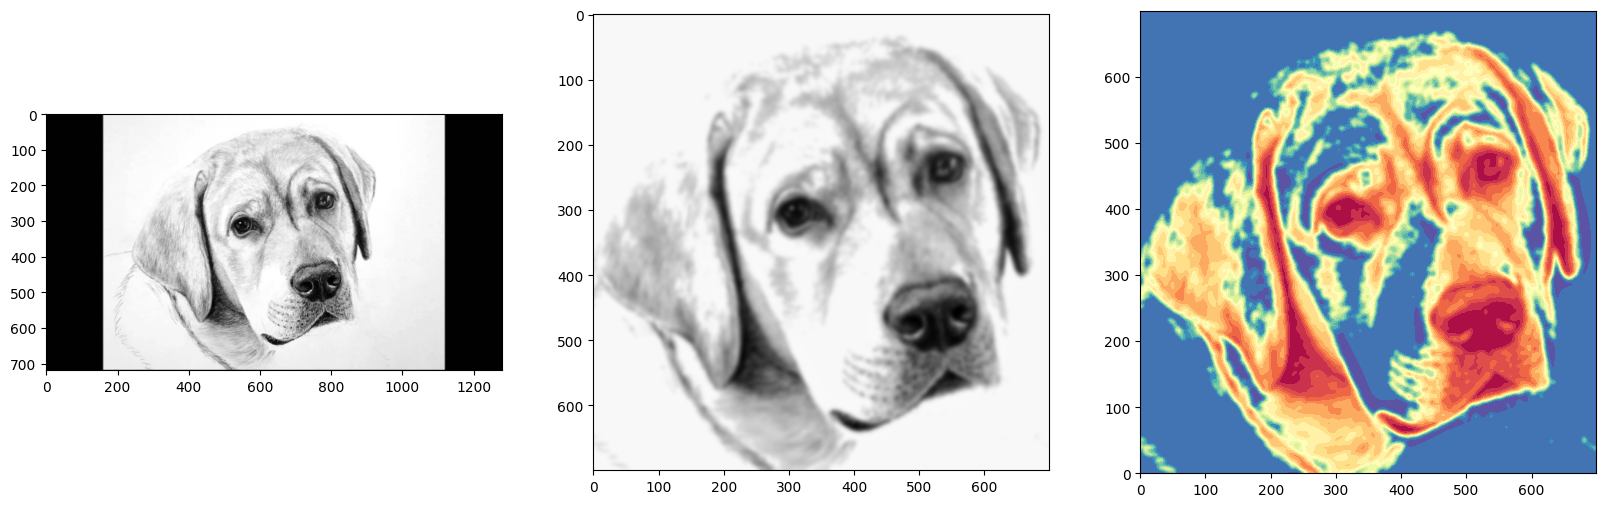

In [6]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 6))
axes[0].imshow(img)
axes[1].imshow(img_density, vmin=0, vmax=1, cmap='gray_r')
axes[2].contourf(img_energy[::-1], 20, vmin=img_energy.min(), vmax=img_energy.max(), cmap='Spectral')

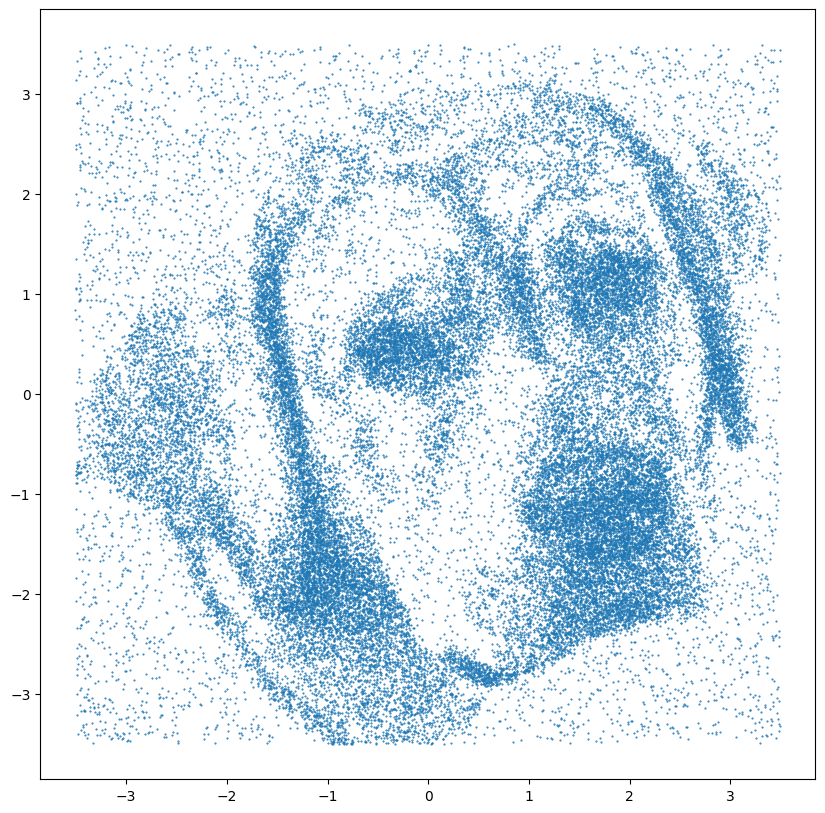

In [7]:
sampler = ImageSampler(img_density[::-1].copy(), mean=mean, scale=scale)
X = sampler.sample(50000)
data = torch.tensor(X, dtype=torch.float32)

plt.figure(figsize=(10, 10))
plt.plot(X[:, 0], X[:, 1], linewidth=0, marker='.', markersize=1)

In [8]:
ndim = X.shape[-1]

In [9]:
ndim

2

In [10]:
target = ImageEnergy(img_energy[::-1].copy(), mean=mean, scale=scale)

In [11]:
dataset = torch.Tensor(X).float().reshape((-1,ndim))
dataset = dataset.to(device)

In [12]:
torch.std(dataset, dim=-1)

tensor([0.0791, 1.8977, 0.6012,  ..., 0.4091, 1.9476, 0.2563], device='cuda:0')

In [13]:
torch.std(dataset)

tensor(1.7017, device='cuda:0')

In [14]:
sig_data = 1.7

In [15]:
print(dataset.shape)

torch.Size([50000, 2])


In [16]:
device

device(type='cuda')

In [17]:
from Flow_Perturbation.src.common import MLP_nonorm, MLP_var
from Flow_Perturbation.src.EDM import loss_EDM
from Flow_Perturbation.src.train import train_model_EDM
model = MLP_nonorm(ndim=ndim,hidden_size=200,hidden_layers=1,emb_size=20).to(device)
batch_size = 128
dataset = dataset.to(device)
print(dataset.shape)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
path = 'models/dog'
model = train_model_EDM(model, device, ndim, sig_data, dataloader, path, num_epoch=81,lr=1e-3, loss_EDM = loss_EDM,decay_steps = 500)
print('Training done!')


torch.Size([50000, 2])
Training model...
0.9986940163480656
Training done!


In [18]:
for param in model.parameters():
    param.requires_grad = False

In [19]:
from Flow_Perturbation.src.EDM import EMDSampler
Sampler = EMDSampler(model, sig_data, device)

exact_dynamics_heun = Sampler.exact_dynamics_heun
heun_torch = Sampler.heun_torch
score_function_rearange = Sampler.score_function_rearange
score_function_1element = Sampler.score_function_1element

(-3.5, 3.5)

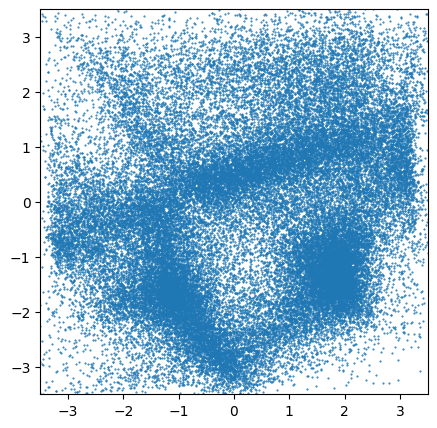

In [20]:
sampN = 50000
tmax = 15.0
epsilon = 0.01
lambdaT = tmax**2
xT = np.sqrt(lambdaT) * torch.randn((sampN, ndim)).to(device)

x0 = exact_dynamics_heun(epsilon, tmax, xT)
Y_init = x0.cpu().detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_init[:, 0], Y_init[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

In [21]:
sampN = 1000
tmax = 15.0
epsilon = 0.01
lambdaT = tmax**2
xT = np.sqrt(lambdaT) * torch.randn((sampN, ndim)).to(device)

x0 = exact_dynamics_heun(epsilon, tmax, xT)
xTp = exact_dynamics_heun(tmax, epsilon, x0)

xT - xTp

tensor([[ 1.9455e-04,  2.7466e-04],
        [-2.2799e-05, -4.5776e-05],
        [-1.7738e-04, -7.0453e-05],
        ...,
        [ 4.1485e-04,  4.7112e-04],
        [-7.4196e-04,  2.4891e-04],
        [-5.5504e-04,  4.5109e-04]], device='cuda:0')

In [22]:
energy_target = target.energy(dataset.cpu())

In [23]:
print(energy_target.mean())

tensor(1.1078)


In [24]:
sampN = 10000
lambdaT = tmax**2

xT = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps = torch.randn_like(xT)

back_coeff = 0.001
x0 = exact_dynamics_heun(epsilon, tmax, xT) + back_coeff * eps # backward dynamics

dxT = xT - exact_dynamics_heun(tmax, epsilon, x0) # this is the error in xT that needs to be matched
eps_squarenorm = torch.sum(eps**2, dim=-1)

In [25]:
from Flow_Perturbation.src.train import CustomDataset, train_model_var
from torch.utils.data import DataLoader

In [26]:
batch_size = 128
dataset = CustomDataset(x0, dxT, eps_squarenorm)
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True, drop_last=True)
# Create the model
model_var = MLP_var(ndim=ndim).to(device)
model_var = train_model_var(model_var, dataloader, back_coeff, num_epoch=51,lr=1e-3,path=path,decay_steps = 500)

0 1.5684824723463793
1.5684824723463793
1 1.0165594862057612
2 0.949579004293833
3 0.935471331461882
4 0.9223600259194007
5 0.9172623012310419
6 0.8987790071047269
7 0.8845816682546567
8 0.8796612031948872
9 0.8709638806489798
10 0.8548333178728055
11 0.8451335575336065
12 0.8541233570147784
13 0.8579087287951739
14 0.8368585407733917
15 0.847730020682017
16 0.8262665118926611
17 0.8319715697031754
18 0.8146626918743818
19 0.8085147096560552
20 0.8104849488307269
21 0.8024061849484077
22 0.8034375271736047
23 0.7730774887097187
24 0.7550089825422336
25 0.7441650965274909
26 0.7342357627856426
27 0.735665866961846
28 0.7105839076714638
29 0.722311298816632
30 0.7129825514096481
31 0.7019188954279973
32 0.7132019553429041
33 0.7095122314416445
34 0.7000927791381494
35 0.7078731610224798
36 0.7125695385994055
37 0.6986328287002368
38 0.6910809305233833
39 0.6932314454745023
40 0.693601022546108
41 0.6806080234356415
42 0.6936812439025977
43 0.6743216996009533
44 0.6771568357944489
45 0.69

In [27]:
for param in model_var.parameters():
    param.requires_grad = False

In [28]:
def get_log_omega(xT, eps):
    x0 = exact_dynamics_heun(epsilon, tmax, xT) + back_coeff * eps
    # forward dynamics
    # xT = exact_dynamics_heun(tmax, 0, x0, mus0, covs0) + forw_coeff * eps_tilde
    forw_coeff = model_var(x0)
    eps_tilde = (xT - exact_dynamics_heun(tmax, epsilon, x0))/forw_coeff
    deltaSt = -0.5 * torch.sum(eps_tilde**2 - eps**2, dim=-1) - ndim * torch.log(forw_coeff).squeeze(-1) + ndim * np.log(back_coeff)
    uz = torch.sum(xT**2/tmax**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi) + ndim*np.log(tmax)
    ux = target.energy(x0.cpu()).reshape(-1).to(device)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [29]:
# generate starting point for the MCMC move
# we need xT_init, eps_init, log_omega_init
# do the backward-forward dynamics, get deltaSt, determine forward coeff
sampN = 50000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)

log_omega_init, x0_init,ux_init = get_log_omega(xT_init, eps_init)

In [30]:
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()

In [31]:
from Flow_Perturbation.src.MC import get_vjp_score_mnoise, get_vjp_score, run_mcmc_and_save, get_jacobian_score, v_jacobian_score_batch
from Flow_Perturbation.src.utils import remove_mean, modify_samples_torch_batched_K
from Flow_Perturbation.src.utils import generate_tsampling
import os
v_jacobian_score = get_jacobian_score(score_function_1element)

In [32]:
if not os.path.exists('models/dog/data_dog'):
    os.makedirs('models/dog/data_dog')

In [33]:
nmcmc =2 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega, device, back_coeff,get_log_omega, 
                                                tmax=tmax, K_x=1, K_eps=1, if_sava=False, if_eps=True,path='models/dog/data_dog/dog-FP',last_steps=1,count_last=1,count_sava=1)

0 tensor(1.7079, device='cuda:0') tensor(36463, device='cuda:0')
1 tensor(1.2588, device='cuda:0') tensor(32672, device='cuda:0')


In [34]:
concatenated_x0_last_steps.shape

torch.Size([50000, 2])

(-3.5, 3.5)

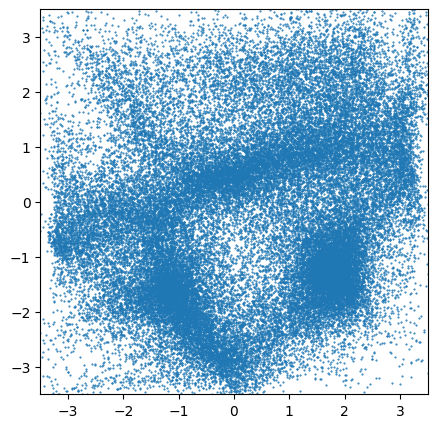

In [35]:
sampN = 50000
tmax = 15.0
epsilon = 0.01
lambdaT = tmax**2
xT = np.sqrt(lambdaT) * torch.randn((sampN, ndim)).to(device)

x0 = exact_dynamics_heun(epsilon, tmax, xT)
Y_init = x0.cpu().detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_init[:, 0], Y_init[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

(-3.5, 3.5)

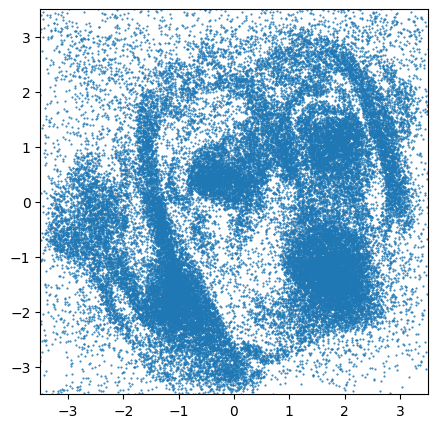

In [36]:
Y_FP = concatenated_x0_last_steps.cpu().detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_FP[:, 0], Y_FP[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

In [37]:
def exact_dynamics_heun_dSt_Huch(tn, tn1, xtn1): # do a lot of Heun steps between tn and tn1 to get the accurate xtn
    ts = generate_tsampling(tn, tn1, 100, 3)
    xt = xtn1 # set the initial x
    dSt = torch.zeros(xt.shape[0]).to(device) # this stores the sum of log(abs(J)) for each step
    
    eps = torch.randn_like(xt)
    _, div_xt = get_vjp_score(xt, ts[len(ts)-1], eps, score_function_rearange)
    #print(score_xt)
    for i in range(len(ts)-1, 0, -1):
        xt_new = heun_torch(ts[i-1], ts[i], xt)
        eps = torch.randn_like(xt_new)
        _, div_xt_new = get_vjp_score(xt_new, ts[i-1], eps, score_function_rearange)

        dSt += (ts[i-1]-ts[i])*(ts[i]*div_xt + ts[i-1]*div_xt_new)/2
        #print((ts[i]-ts[i-1]))
        
        div_xt = div_xt_new
        xt = xt_new
    return xt, -dSt

 
def get_log_omega_J(xT, eps=None):
    x0, deltaSt = exact_dynamics_heun_dSt_Huch(epsilon, tmax, xT) 
    uz = torch.sum(xT**2/tmax**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi) + ndim*np.log(tmax)
    ux = target.energy(x0.cpu()).reshape(-1).to(device)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [38]:

sampN = 50000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)

log_omega_init, x0_init,ux_init = get_log_omega_J(xT_init, eps_init)

In [39]:
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()

In [40]:
nmcmc =2 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega, device, back_coeff,get_log_omega_J, 
                                                tmax=tmax, K_x=1, K_eps=1,if_sava=False, if_eps=False,path='models/dog/data_dog/dog-H1',last_steps=1,count_last=1,count_sava=1)

0 tensor(1.5672, device='cuda:0') tensor(36161, device='cuda:0')
1 tensor(1.2807, device='cuda:0') tensor(31913, device='cuda:0')


(-3.5, 3.5)

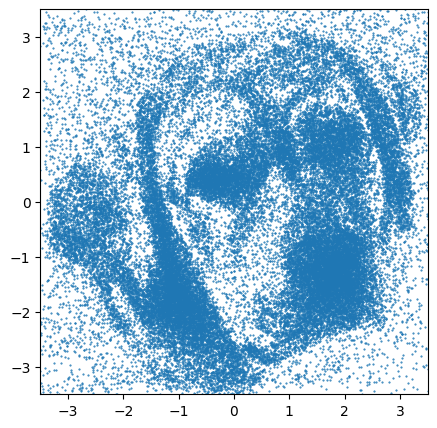

In [41]:
Y_H1 = concatenated_x0_last_steps.cpu().detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_H1[:, 0], Y_H1[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

In [42]:
def exact_dynamics_heun_dSt_Huch(tn, tn1, xtn1): # do a lot of Heun steps between tn and tn1 to get the accurate xtn
    ts = generate_tsampling(tn, tn1, 100, 3)
    xt = xtn1 # set the initial x
    dSt = torch.zeros(xt.shape[0]).to(device) # this stores the sum of log(abs(J)) for each step
    nnoise = 10 # we want to average over 10 noises
    eps = torch.randn((nnoise, xt.shape[0], xt.shape[1])).to(device)
    _, div_xt = get_vjp_score_mnoise(xt, ts[len(ts)-1], eps, score_function_rearange)
    for i in range(len(ts)-1, 0, -1):
        xt_new = heun_torch(ts[i-1], ts[i], xt)

        eps = torch.randn((nnoise, xt.shape[0], xt.shape[1])).to(device)
        _, div_xt_new = get_vjp_score_mnoise(xt_new, ts[i-1], eps, score_function_rearange)

        dSt += (ts[i-1]-ts[i])*(ts[i]*div_xt + ts[i-1]*div_xt_new)/2
        
        div_xt = div_xt_new
        xt = xt_new
    return xt, -dSt

def get_log_omega_J(xT, eps=None):
    x0, deltaSt = exact_dynamics_heun_dSt_Huch(epsilon, tmax, xT) 
    uz = torch.sum(xT**2/tmax**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi) + ndim*np.log(tmax)
    ux = target.energy(x0.cpu()).reshape(-1).to(device)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [43]:
sampN = 50000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)

log_omega_init, x0_init,ux_init = get_log_omega_J(xT_init, eps_init)

In [44]:
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()

In [45]:
nmcmc =2 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega, device, back_coeff,get_log_omega_J, 
                                                    tmax=tmax, K_x=1, K_eps=1, if_sava=False, if_eps=False,path='models/dog/data_dog/dog-H10',last_steps=1,count_last=1,count_sava=1)

0 tensor(1.6778, device='cuda:0') tensor(37712, device='cuda:0')
1 tensor(1.3985, device='cuda:0') tensor(34673, device='cuda:0')


(-3.5, 3.5)

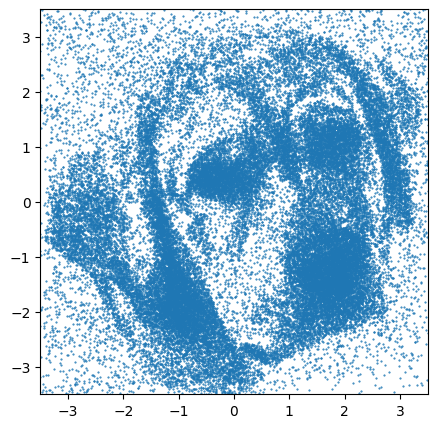

In [46]:
Y_H10 = concatenated_x0_last_steps.cpu().detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_H10[:, 0], Y_H10[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)


In [47]:
def exact_dynamics_heun_dSt(tn, tn1, xtn1): # do a lot of Heun steps between tn and tn1 to get the accurate xtn
    ts = generate_tsampling(tn, tn1, 100, 3)
    xt = xtn1 # set the initial x
    dSt = torch.zeros(xt.shape[0]).to(device) # this stores the sum of log(abs(J)) for each step
    
    jj_score_xt = v_jacobian_score_batch(xt, ts[len(ts)-1], v_jacobian_score,batch_size=5000)
    div_xt = torch.einsum("...ii", jj_score_xt)
    for i in range(len(ts)-1, 0, -1):
        xt_new = heun_torch(ts[i-1], ts[i], xt)
        jj_score_xt_new = v_jacobian_score_batch(xt_new, ts[i-1], v_jacobian_score,batch_size=5000)
        div_xt_new = torch.einsum("...ii", jj_score_xt_new)
        dSt += (ts[i-1]-ts[i])*(ts[i]*div_xt + ts[i-1]*div_xt_new)/2
        div_xt = div_xt_new
        xt = xt_new
        del xt_new,jj_score_xt_new,div_xt_new
    return xt, -dSt
 
def get_log_omega_J(xT, eps=None):
    x0, deltaSt = exact_dynamics_heun_dSt(epsilon, tmax, xT) 
    uz = torch.sum(xT**2/tmax**2, dim=-1)/2.0  + 0.5*ndim*np.log(2*np.pi) + ndim*np.log(tmax)
    ux = target.energy(x0.cpu()).reshape(-1).to(device)
    log_omega = -ux + deltaSt + uz

    return log_omega, x0, ux

In [48]:

sampN = 50000

xT_init = np.sqrt(lambdaT) * torch.randn(sampN, ndim).to(device)
eps_init = torch.randn_like(xT_init)

log_omega_init, x0_init,ux_init = get_log_omega_J(xT_init, eps_init)

In [49]:
xT = xT_init.clone()
eps = eps_init.clone()
x0 = x0_init.clone()
log_omega = log_omega_init.clone()
ux = ux_init.clone()

In [50]:
nmcmc =2 # number of MCMC steps
concatenated_x0_last_steps = run_mcmc_and_save(nmcmc, ux, x0, xT, eps, log_omega, device, back_coeff,get_log_omega_J, 
                                                tmax=tmax, K_x=1, K_eps=1, if_sava=False, if_eps=False,path='models/dog/data_dog/dog-J',last_steps=1,count_last=1,count_sava=1)

0 tensor(2.0696, device='cuda:0') tensor(38285, device='cuda:0')
1 tensor(1.4220, device='cuda:0') tensor(35139, device='cuda:0')


(-3.5, 3.5)

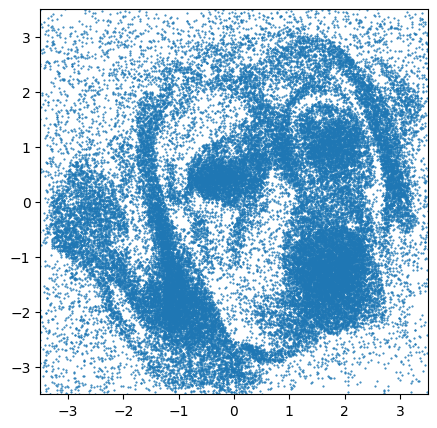

In [51]:
Y_J = concatenated_x0_last_steps.cpu().detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_J[:, 0], Y_J[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

(-3.5, 3.5)

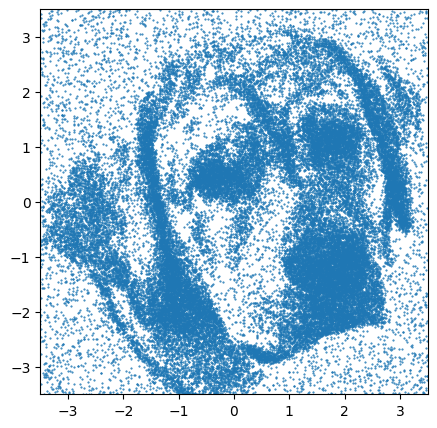

In [52]:
sampler = ImageSampler(img_density[::-1].copy(), mean=mean, scale=scale)
X = sampler.sample(50000)
data = torch.tensor(X, dtype=torch.float32)

Y_RNVP = data.cpu().detach()

plt.figure(figsize=(5, 5))
plt.plot(Y_RNVP[:, 0], Y_RNVP[:, 1], linewidth=0, marker='.', markersize=1)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

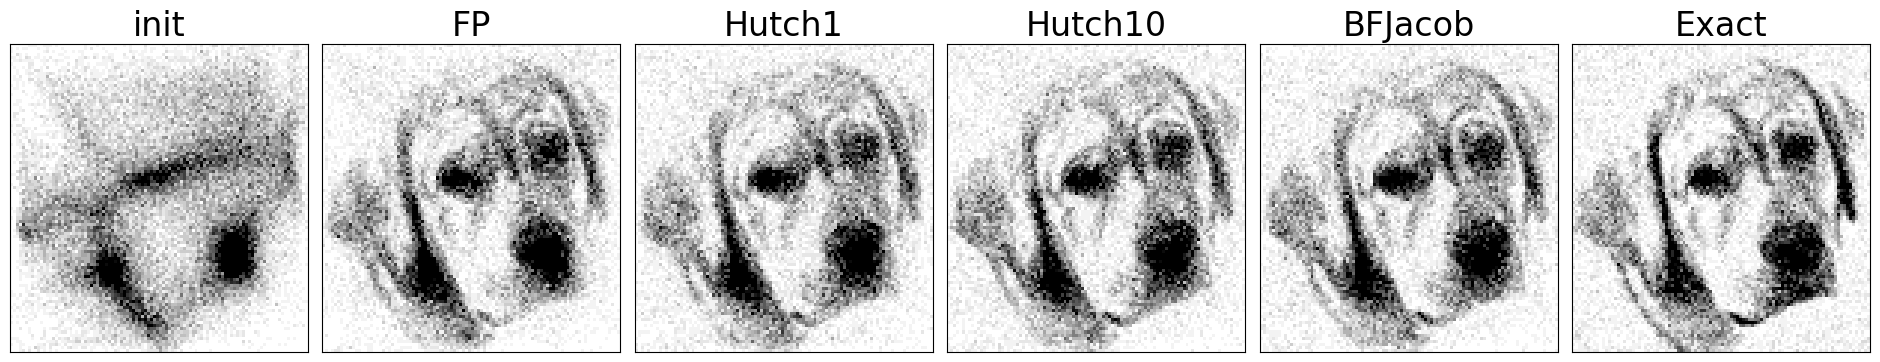

In [53]:
nbins = 100
vmax = 20
xrange=(-3.5, 3.5)
yrange=(-3.5, 3.5)

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(24, 4))
fig.subplots_adjust(wspace=0.05)

axes[0].set_title('init', fontsize=24)
axes[1].set_title('FP', fontsize=24)
axes[2].set_title('Hutch1', fontsize=24)
axes[3].set_title('Hutch10', fontsize=24)
axes[4].set_title('BFJacob', fontsize=24)
axes[5].set_title('Exact', fontsize=24)
axes[0].hist2d(Y_init.numpy()[:, 0], Y_init.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[1].hist2d(Y_FP.numpy()[:, 0], Y_FP.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[2].hist2d(Y_H1.numpy()[:, 0], Y_H1.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[3].hist2d(Y_H10.numpy()[:, 0], Y_H10.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[4].hist2d(Y_J.numpy()[:, 0], Y_J.numpy()[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
axes[5].hist2d(X[:, 0], X[:, 1], bins=nbins, vmax=vmax, range=[xrange, yrange], cmap='gray_r');
for i in range(6):
    axes[i].set_xlim(xrange[0], xrange[1])
    axes[i].set_ylim(yrange[0], yrange[1])
    axes[i].set_xticks([])
    axes[i].set_yticks([])